In [ ]:
# import the necessary packages
import tensorflow 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import os

In [ ]:
import sys
 
 
print("User Current Version:-", sys.version)

User Current Version:- 3.9.16 (main, Dec  7 2022, 01:11:51) 
[GCC 9.4.0]


In [ ]:

from platform import python_version
 
 
print("Current Python Version-", python_version())

Current Python Version- 3.9.16


In [ ]:
print(tensorflow.__version__)

2.11.0


In [ ]:

DIRECTORY = r"/content/drive/MyDrive/face mask detection"
CATEGORIES = ["with_mask", "without_mask"]

# grab the list of images in our dataset directory, then initialize
# the list of data (i.e., images) and class images
print("[INFO] loading images...")

data = []
labels = []

for category in CATEGORIES:
    path = os.path.join(DIRECTORY, category)
    for img in os.listdir(path):
    	img_path = os.path.join(path, img)
    	image = load_img(img_path, target_size=(224, 224))
    	image = img_to_array(image)
    	image = preprocess_input(image)

    	data.append(image)
    	labels.append(category)


[INFO] loading images...


/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [ ]:
INIT_LR = .0001
EPOCHS = 20
BS = 32

In [ ]:
# perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

data = np.array(data, dtype="float32")
labels = np.array(labels)

In [ ]:
(trainX, testX, trainY, testY) = train_test_split(data, labels,
	test_size=0.20, stratify=labels, random_state=42)


In [ ]:
aug = ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

In [ ]:
 #load the MobileNetV2 network, ensuring the head FC layer sets are
# left off
baseModel = MobileNetV2(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))

# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = MaxPooling2D(pool_size=(2, 2))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)

In [ ]:
#base_learning_rate = 0.0001
#model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),loss=tf.keras.losses.binary_crossentropy(),metrics=['accuracy'])

In [ ]:
# *not* be updated during the first training process
for layer in baseModel.layers:
	layer.trainable = False

# compile our model
print("[INFO] compiling model...")
opt = Adam(learning_rate=INIT_LR)
model.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])

[INFO] compiling model...


In [ ]:
callback=tf.keras.callbacks.EarlyStopping(
    monitor="accuracy",
    min_delta=0,
    patience=15,
    verbose=2,
    mode="auto",
    baseline=None,
    restore_best_weights=False,
)

In [ ]:
H = model.fit(
	aug.flow(trainX, trainY, batch_size=BS),
	steps_per_epoch=len(trainX) // BS,
	validation_data=(testX, testY),
	validation_steps=len(testX) // BS,
	epochs=EPOCHS,callbacks=[callback])

Epoch 1/20
95/95 [==============================] - 52s 412ms/step - loss: 0.1838 - accuracy: 0.9446 - val_loss: 0.0554 - val_accuracy: 0.9817
Epoch 2/20
95/95 [==============================] - 37s 392ms/step - loss: 0.0644 - accuracy: 0.9815 - val_loss: 0.0414 - val_accuracy: 0.9870
Epoch 3/20
95/95 [==============================] - 37s 387ms/step - loss: 0.0564 - accuracy: 0.9855 - val_loss: 0.0372 - val_accuracy: 0.9870
Epoch 4/20
95/95 [==============================] - 37s 388ms/step - loss: 0.0545 - accuracy: 0.9832 - val_loss: 0.0326 - val_accuracy: 0.9857
Epoch 5/20
95/95 [==============================] - 38s 403ms/step - loss: 0.0445 - accuracy: 0.9862 - val_loss: 0.0230 - val_accuracy: 0.9909
Epoch 6/20
95/95 [==============================] - 37s 388ms/step - loss: 0.0370 - accuracy: 0.9898 - val_loss: 0.0343 - val_accuracy: 0.9896
Epoch 7/20
95/95 [==============================] - 37s 386ms/step - loss: 0.0344 - accuracy: 0.9888 - val_loss: 0.0344 - val_accuracy: 0.9922

In [ ]:
predIdxs = model.predict(testX, batch_size=BS)


24/24 [==============================] - 2s 60ms/step


In [ ]:
predIdxs = np.argmax(predIdxs, axis=1)


In [ ]:

# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs,
	target_names=lb.classes_))

              precision    recall  f1-score   support

   with_mask       0.99      1.00      0.99       383
without_mask       1.00      0.99      0.99       384

    accuracy                           0.99       767
   macro avg       0.99      0.99      0.99       767
weighted avg       0.99      0.99      0.99       767



In [ ]:
model.save("mask_detector.model", save_format="h5")

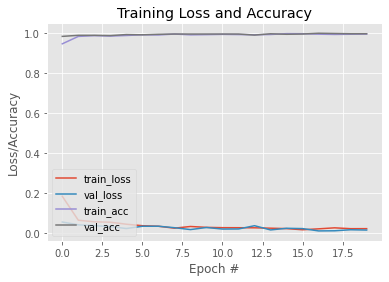

In [ ]:
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.png")